# Building A Basic AI RAG Assistant Tutorial

## Introduction
In this tutorial, we will walk through the process of building a simple basic AI Assistant RAG application using Langchain & Langgraph. The assistant will have the ability to call a tool that can search the web to retrieve information. We will cover document (pdf) loading, splitting/chunking, creating a vectorstore to ingest data using Chroma, setting up prompts and also be able to play around by chatting with our document.

### Step 1: Import Required Libraries
First, we need to import the necessary libraries for our project. 

In [47]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from dotenv import load_dotenv


In [4]:
load_dotenv()

True

In [5]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# Part 1

## Set Up a RAG Pipeline with Langchain

### Step 1: Load Documentation

In [28]:
loader = PyPDFLoader("principles_of_marketing.pdf")
pages = loader.load_and_split()
pages

[Document(metadata={'source': 'principles_of_marketing.pdf', 'page': 0}, page_content='Figur e3.1Understanding consumer pur chasing decisions is important because it allo ws companies to better influence those\nbehaviors. (cr edit: modification of work “Hong Kong Str eet Market ” by Bernar d Spr agg. NZ/flickr , Public Domain)\nChapter Outline\n3.1Understanding Consumer Markets and Buying Behavior\n3.2Factors That Influence Consumer Buying Behavior\n3.3The Consumer Pur chasing Decision Pr ocess\n3.4Ethical Issues in Consumer Buying Behavior\nIn the Spotlight\nTher e is no denying that C OVID-19 affected the entir e economy , but fast-food r estaur ants wer e particularly\nhard-hit when indoor dining was r estricted. McDonald’ squickly adapted during the pandemic b y focusing on\nwhat it calls the 3 Ds: digital, delivery , and drive-thr ough.\nMcDonald’ s had a str ong position in terms of digital inno vation e ven befor e the pandemic. It had installed self-\norder kiosks in its r esta

### Step 2: Split Documentation

In [29]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=40)
splits = text_splitter.split_documents(pages)
splits

[Document(metadata={'source': 'principles_of_marketing.pdf', 'page': 0}, page_content='Figur e3.1Understanding consumer pur chasing decisions is important because it allo ws companies to better influence those'),
 Document(metadata={'source': 'principles_of_marketing.pdf', 'page': 0}, page_content='behaviors. (cr edit: modification of work “Hong Kong Str eet Market ” by Bernar d Spr agg. NZ/flickr , Public Domain)\nChapter Outline\n3.1Understanding Consumer Markets and Buying Behavior'),
 Document(metadata={'source': 'principles_of_marketing.pdf', 'page': 0}, page_content='3.2Factors That Influence Consumer Buying Behavior\n3.3The Consumer Pur chasing Decision Pr ocess\n3.4Ethical Issues in Consumer Buying Behavior\nIn the Spotlight'),
 Document(metadata={'source': 'principles_of_marketing.pdf', 'page': 0}, page_content='In the Spotlight\nTher e is no denying that C OVID-19 affected the entir e economy , but fast-food r estaur ants wer e particularly'),
 Document(metadata={'source': 'p

### Step 3: Create a Vectorstore to Index contents of the document

In [30]:
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings(model='text-embedding-3-small'))
vectorstore

### Step 4: Setup Retriever

In [31]:
retriever = vectorstore.as_retriever()
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x3035ed1d0>, search_kwargs={})

### Step 5: Setup RAG Prompt Template

In [32]:
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."),
    ("user", "context: {context}\n\nquestion: {question}")    
])

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### Step 6: Create RAG Chain

In [33]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

### Step 6: Test Output

In [35]:
rag_chain.invoke("What is consumer buying behaviour?")

'Consumer buying behavior refers to the decisions and actions that individuals undertake when purchasing products or services. It encompasses the processes involved in selecting, purchasing, using, and disposing of goods and services. Understanding this behavior is crucial for marketers to effectively target and meet consumer needs.'

# Part 2 

## Set Up Langgraph Router 

In [15]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain.tools import tool
from langchain_community.tools import TavilySearchResults
from pydantic import BaseModel, Field

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

### Step 1: Create Tools

#### (i) Make the RAG Chain Created in Part 1 as a Tool

In [16]:
# Create Rag Chain as a Tool

class RagTool(BaseModel):
    user_query: str = Field(description="The user's input query to use for RAG")


@tool("rag_tool", args_schema=RagTool, return_direct=True)
def rag_tool(user_query: str) -> str:
    ''' Invokes the RAG chain To Provide an Answer to the User's Query'''
    response = rag_chain.invoke(user_query)
    return response

print(rag_tool.name)
print(rag_tool.description)
print(rag_tool.args)
print(rag_tool.return_direct)


rag_tool
Invokes the RAG chain To Provide an Answer to the User's Query
{'user_query': {'description': "The user's input query to use for RAG", 'title': 'User Query', 'type': 'string'}}
True


#### (ii) Create an Additional Tool that gives the LLM the ability to search the Web

In [17]:
# Create a Web Search Tool

class WebSearch(BaseModel):
    user_query: str = Field(description="The user's input query to use for Web Search")
    
@tool("web_search_tool", args_schema= WebSearch, return_direct=True)
def web_search_tool(user_query: str) -> str:
    ''' Runs a web search to provide an answer based on the user's query '''
    search = TavilySearchResults(
        max_results = 5,
        search_depth = "advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=True
    )
    
    results = search.invoke({"query":user_query})
    
    return {"messages": results}

print(web_search_tool.name)
print(web_search_tool.description)
print(web_search_tool.args)
print(web_search_tool.return_direct)

web_search_tool
Runs a web search to provide an answer based on the user's query
{'user_query': {'description': "The user's input query to use for Web Search", 'title': 'User Query', 'type': 'string'}}
True


#### {iii} Bind the LLM with these tools

In [18]:
tools = [rag_tool, web_search_tool]
llm_with_tools = llm.bind_tools(tools)

### Step 2: Create a Robust System Message for the Agent

In [36]:
# Create a System Message

sys_msg = SystemMessage(content=
    """You are an AI assistant capable of answering questions using two tools provided to you:
    
        1. **Retrieval-Augmented Generation (RAG) Pipeline Tool**:
        - You have access to a pre-configured RAG pipeline, which is capable of retrieving relevant information about a document containing a chapter from a marketing textbook about Consumer Markets and Purchasing Behavior.
        - If the user's input is related to the topic of marketing, trigger the RAG tool.

        2. **Tavily Web Search Tool**:
        - You can use the Tavily web search tool to fetch real-time information from the web for any queries not covered by the RAG pipeline, such as current events, general knowledge, or even topics unrelated to marketing.

    Deciding when to invoke a tool:
    - Use the **RAG Pipeline Tool** if the user's input is related to 'Sound'.
    - Use the **Tavily Web Search Tool** if the user's query is about 'Sound' that the document in RAG pipeline does not cover or requires real-time or broader web-based information.
    
    Do not hallucinate your answer. Use the tools provided to provide the best answer possible to the user's query.

    User Question: "{user_query}"""
)


### Step 3: Create an Assistant Node

In [37]:
# Create Assistant Node

def assistant(state: MessagesState):
    response = llm_with_tools.invoke([sys_msg] + state["messages"]) # The input our system message plus a dictionary `{"messages": state["messages"]}`, which sets the initial value for our state dict.
    return {"messages": response}
    

### Step 4: Build Graph Using Langgraph 

To Learn More About How to Build Langgraph graphs, check out this link: "https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot"

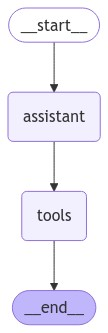

In [48]:
builder = StateGraph(MessagesState)

# Define Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "assistant")
builder.add_edge("assistant", "tools")
builder.add_edge("tools", END)


graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### Step 5: Test Responses

In [39]:
response = graph.invoke({"messages": HumanMessage(content="Hi")}, {"configurable": {"thread_id": "1"}})

In [40]:
for message in response['messages']:
    print(message.content)

Hi
Hello! How can I assist you today?


In [42]:
response = graph.invoke({"messages": HumanMessage(content="How did McDonald's cope with the pandemic as per the details covered in the chapter?")}, {"configurable": {"thread_id": "1"}})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

How did McDonald's cope with the pandemic?
================================== Ai Message ==================================
Tool Calls:
  web_search_tool (call_It2aZSq13zTGcYZ7fcDq5naN)
 Call ID: call_It2aZSq13zTGcYZ7fcDq5naN
  Args:
    user_query: How did McDonald's cope with the pandemic?
================================= Tool Message =================================
Name: web_search_tool

{"messages": [{"url": "https://d3.harvard.edu/platform-digit/submission/committing-to-the-core-how-mcdonalds-innovated-to-survive-and-thrive-during-the-covid-19-pandemic/", "content": "And though many fast-casual chains quickly adapted to stay afloat during their industry's most trying time — one in particular not onl